In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Callable, Dict, List, Tuple, Union
import numpy as np
import numpy.random as rn
from itertools import product
from importlib import reload
import coursework as cw

You wake up to the beeping tune of the radio receiver. There's a pattern to it, a syncopation, that triggers your amydgala. Your heart beats faster. You come to. You realise the year is 2150. The world you live in is one where information is monopolised by technocracy.

But you're a member of the Resistance, who fights for the Freedom of Information, and you're on duty at a secret telecommunications tower. You've been expecting a message, but unfortunately, since the atmosphere collapsed, cosmic radiation has been causing you trouble and the message you received is undecipherable. It's not a matter of encryption, no, for encryption has long been close-sourced, and the Resistance hasn't managed to learn anything about it yet. It's simply a matter of errors in the data.

In [3]:
with open("secret.txt", "r") as f:
    bits = f.read()
message = np.array([int(b) for b in bits]).astype(int)


Thankfully, in the library of sacred texts of Free Information Theory, an old [paper](https://ia802906.us.archive.org/17/items/bstj29-2-147/bstj29-2-147.pdf) from 200 years ago, by one Hamming, seems to contain the solution...


# Hamming codes

Hamming codes are a set of **error correction** codes that organise the message in blocks, and using redundant bits that store the parity for overlapping segments of each block, they can detect and correct bit-flipping errors. A Hamming code is defined for a number of parity bits $m$, which can encode a message of length $k=2^m-m-1$ data bits into a code of length $n=2^m-1$ including both data and parity bits $(n = k+m)$.

For example, the $Hamming(3,1)$ code is the repetition code where each bit is repeated 3 times, thus there are $m=2$ parity bits - which are simply equal to the corresponding data bit. In the $Hamming(7,4)$ code, 4 bits are encoded with $m=3$ parity bits.


## Your task

Your task is to decode the binary message received from the other Resistance fighters, correct the errors, and restore it to text. You're fairly sure the Hamming code was used but not certain with what number of parity bits.

Once you decode the message, since you want to avoid this happening in the future, so you should test the limits of your encoding by implementing a noisy channel, simulating many messages being sent, and running statistics and measures.

**Important information**: You are expected to submit your solution as an an updated version of the `coursework.py` file containing your implementation of all functions that currently raise a `NotImplementedError`. Do not edit any other functions. To streamline your development process, you may want to import your solution and use the `reload` function from the `importlib` module frequently, to make sure the latest version of your implementation is loaded.

The rest of this notebook will provide more concrete guidelines for implementation. Functions that convert text to a sequence of bits and vice-versa have already been implemented in the system, so you can use them to binary encode and decode your messages. Open `coursework.py`, check out the functions `char2bits`, `bits2char`, `text2bits` and `bits2text`, and make sure you understand them.

We can check these work as expected:

In [4]:
cw.bits2text(cw.text2bits("Hello world"))

'hello world'

## On bits and bitwise functions

Since Hamming codes are implemented on binary sequences, it is best to work with a bit type. In Python, the `bool` type, consisting of `True` and `False`, can be used for encoding bits.

Python also supports bitwise functions: not `~`, and `&`, or `|`,  and xor `^`, which apply to booleans as well as integers.

Under the hood, though, Python **casts** these boolean values to `int`, for example, in a sum, which means you can combine `int` and `bool` in the same operation...

In [5]:
True & 0, 1 & 0, 1 & True, True * 0, True * False, 1 * True

(0, 0, 1, 0, 0, 1)

You may notice that `&` is the same as `*`, but if you used `+` instead of `|`, or simply `~True`, the underlying integers will be revealed...

In [6]:
True + True

2

In [7]:
~True

-2

### Bit operators

The bit operations below apply to both `bool` and `int`:

     a or  b = max(a, b)
     a and b =  a * b
     a xor b = (a + b) % 2
       not a =  1 - a

We suggest you store your bit sequences as `numpy` arrays so the operators can be broadcast over. For example, to compute the 'not' of an array of bits, you can simply run:

In [8]:
bits = np.array([0, 1, 0, 1])
1 - bits

array([1, 0, 1, 0])

You may find also find `numpy`'s matrix product (`@`) useful:

In [9]:
id = np.identity(4)
ones = np.ones((3, 4))

m = ones @ id
m

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

Be careful about **types**! Operations like multiplication or mod will yield `float` numbers (as you can see, in the matrix above). It is best you cast everything to `int` or, if you like to work with `bool`, then to be safe cast as `int` first, like below:

In [10]:
id.astype(int).astype(bool)

array([[ True, False, False, False],
       [False,  True, False, False],
       [False, False,  True, False],
       [False, False, False,  True]])

### Bit parity

The parity of a bit sequence is given by the number of `1`s in the sequence. Normally, the parity of a sequence is `0` if there's an even number of `1`'s, and is `1` if there is an odd number of `1`'s. A **parity bit** for a binary sequence, thus, indicates whether the parity of that sequence is odd or even. Calculating parity can be done by simply counting the number of bits, or by using...

### Bit masking

A **bit mask** is a sequence of bits that is used to set, extract or toggle specific bits form an array. The bits that are set, extracted or toggled are at the same position as the `1`s in the mask. For example:

- The `and`-mask will **extract** all bits at positions that hold a `1`.
- The `xor`-mask will **toggle** all bits at positions that hold a `1`.

You may find `and`-masking useful to select the groups of bits in the block to compute parity for. Summing the result yields the parity for that group of bits.

In [11]:
mask = np.array([0, 1, 1, 1])
value = np.array([1, 0, 1, 1])

In [12]:
mask & value, mask ^ value

(array([0, 0, 1, 1]), array([1, 1, 0, 0]))

# Task 1a
## Hamming encoding

The first task is to create a Hamming code for a given number of parity bits $m$ and use it to encode $2^m-m-1$ bits into a code of length $2^m-1$. The Hamming code is built from bits of the original message, called **data bits**, added in between **parity bits** that cover specific groups of data bits. These parity bits function as a "checksum" to check the integrity of the original message.

The most elegant way to compute the Hamming code is to use a **generator matrix** $\mathbf{G}$ of size $(k, n)$, which maps data vectors to codewords, taking advantage of the formulation of the `XOR` function as a sum modulo two. Then the codeword is given by multiplying the matrix by the message (refered to as the **source**), as such:

$$\mathbf{t} = G^\top \mathbf{s} \mod 2$$

Here is an illustration of how the parity bits in a $Hamming(7,4)$ are used:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Hamming%287%2C4%29.svg/450px-Hamming%287%2C4%29.svg.png)

- p1 covers d1, d2, d4
- p2 covers d1, d3, d4
- p3 covers d2, d3, d4

These are usually arranged as $\{p_1, p_2, d_1, p_3, d_2, d_3, d_4\}$.


**In general**, for any $Hamming(n, k)$ code, parity bits $1, 2, ..., m$ are always placed at positions given by $2^0, 2^1... 2^{m-1}$.




### Your implementation

The first step is finding the positions covered by each parity bit. This will be useful for both encoding and decoding. Stacking all the positions covered by each of the $m$ parity bits produces the **parity check matrix**. The parity check matrix, usually denoted by $H$, has size $(m, n)$ and is constructed such that $H_{ij}=1$ if parity bit $i$ covers codeword bit $j$.

**In the general case**, parity bit $i$ will cover $2^i$ bits, then skip $2^i$ bits, starting at position $2^{i-1}$ and until the end of the block. By looking at the parity check matrix for $Hamming(7,4)$, you should be able to spot the more general pattern:

$$H = \begin{pmatrix}
1 & 0 & 1 & 0 & 1 & 0 & 1 \\
0 & 1 & 1 & 0 & 0 & 1 & 1 \\
0 & 0 & 0 & 1 & 1 & 1 & 1
\end{pmatrix}$$

Once you have implemented a function to create the parity check matrix, you can use it to easily create the generator matrix. The generator matrix of size $(k,n)$ can be constructed as follows:

* The data columns of the generator are the $k\times k$ identity matrix.
* The parity columns of the generator are the data rows of $H^\top$.

As an example, the generator matrix for the $Hamming(7,4)$ code is:

$$G = \begin{pmatrix}
1 & 1 & 1 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & 1 & 1 & 0 & 0 \\
0 & 1 & 0 & 1 & 0 & 1 & 0 \\
1 & 1 & 0 & 1 & 0 & 0 & 1 \\
\end{pmatrix}$$

You may choose to implement your code through matrix multiplication operation on binary codes, or by looping through the $n$ positions in the target and using Boolean and/or string operations. Implementation is up to you, but in both cases, starting with the parity positions is useful. You can check that your implementation behaves as expected by multiplying the $m=3$ Hamming generator times all 16 binary vectors of length $k=4$ and checking that the resulting codewords match those in the first slide of the "Hamming codes" section of the lecture notes.

**Task**: Implement a function that returns the parity check matrix for a given number of parity bits $m$, another function that returns the generator matrix, and another function to encode a data vector for any number of parity bits $m$. Remember reloading your solution frequently as you implement it.

In [13]:
# For some integer m and some np.ndarray data, you should be able to call:
m = 3

for i in range(2 ** (m + 1)):
    vec = np.array(list(np.binary_repr(i, width=4)), dtype=int)
    encoded = cw.hamming_encode(vec, m)
    print(encoded)

[0 0 0 0 0 0 0]
[1 1 0 1 0 0 1]
[0 1 0 1 0 1 0]
[1 0 0 0 0 1 1]
[1 0 0 1 1 0 0]
[0 1 0 0 1 0 1]
[1 1 0 0 1 1 0]
[0 0 0 1 1 1 1]
[1 1 1 0 0 0 0]
[0 0 1 1 0 0 1]
[1 0 1 1 0 1 0]
[0 1 1 0 0 1 1]
[0 1 1 1 1 0 0]
[1 0 1 0 1 0 1]
[0 0 1 0 1 1 0]
[1 1 1 1 1 1 1]


# Task 1b
## Error checking

The next task is to check for errors in a Hamming-encoded message.

Suppose you have a received codeword $\mathbf{r}$ which is the Hamming encoding of data block $\mathbf{s}$, possibly subject to noise. Extracting the data bits from their corresponding positions _should_ give back $\mathbf{s}$, but since it is possible that errors may have occured, we denote this $\mathbf{s'}$. The error checking consists of computing the parity bits again on $\mathbf{s'}$, and checking they match with the parity bits  in $\mathbf{r}$, for example by `and`-masking. If they do, then it means in $\mathbf{s}=\mathbf{s'}$.

The elegant way presented by Hamming in his paper is done with the parity check matrix $H$. Multiplying the codeword with the parity check matrix produces a **syndrome** vector $\mathbf{z}$, such that

$$\mathbf{z} = H \mathbf{r}$$

Depending on how many bit-flips happened during the noisy channel communication, this vector can look differently:

- If there are no errors, the syndrome is 0 everywhere, and decoding can proceed by extracting the data bits from the codeword.
- If there is exactly one error, the syndrome will have non-zero entries but we will be able to correct the error. Once the position of the bit flip has been determined, the bit can be flipped again and the data bits extracted as in the previous point.
- If there are two or more errors, the code is unable to detect or correct the errors.

Hamming designed the codes with parity bits ordered in this way because in the case of a single bit flip, the syndrome actually encodes the position of the flipped bit. Suppose the syndrome in $Hamming(7,4)$ is $[1,1,0]^T$. Then the bit flip had occured on position 3!

**Task**: Implement a function that can decode a codeword from a Hamming code with any $m$, while correcting single bit flip errors. Remember reloading your solution frequently as you implement it.


In [14]:
m = 3
code = np.array([1, 1, 0, 0, 1, 0, 0])  # bit flip at position 6
decoded = np.array([0, 1, 1, 0])
assert np.all(decoded == cw.hamming_decode(code, m))

To check your implementation succeeded, at least for error-less codes, you may check that:

In [15]:
s = np.array([1, 0, 1, 1], dtype=bool)

assert all(cw.hamming_decode(cw.hamming_encode(s, 3), 3) == s)

You may also test cases with one and two bit flips to check your implementation behaves as expected.

Make sure you explicitly **copy** the code when flipping the bits, otherwise the original array containing the code will be affected too.

In [16]:
s = np.array([1, 0, 1, 1], dtype=bool)
t = cw.hamming_encode(s, 3)
r = t.copy()
r[2] = 1 - r[2]
s2 = cw.hamming_decode(r, 3)
s2

array([1, 0, 1, 1])

In [17]:
r[0] = 1 - r[0]
s2 = cw.hamming_decode(r, 3)
s2

array([0, 0, 1, 1])

# Task 1c
## Decoding

It is finally time to discover the message the Resistance has sent to you, loaded at the beginning of this notebook in `message`.

Split `message` in chunks of length $2^m-1$ and try out `hamming_decode`, with different $m$'s. Flatten the output and pass it through `bin2text`.

What was the original $m$ used to encode this file? What does the text say?

**Task**: Find the original $m$ that was used to encode `secret.txt`. Write a function to load the text, split it in chunks of $n=2^m-1$, decode it, flatten it, convert it to text and return the resulting text. Remember reloading your solution frequently as you implement it.


In [18]:
print(cw.decode_secret(message))

the bell system technical journal
vol. xx, april, 1950, no. 2
error detecting and error correcting codes
by r. w. hamming
1. introduction
he author was"ìed to the studyªgiven in this paper from a consideration of large scale computing machines in which a large number of
operations must be performed without a single error in the end result- this
problem of dÏing things right on a large scale is not essentially new in a
telephone central office, for example, a very large nuiber of operations are
performed w(	le the errors leading to wrong numbers are kept wedl under
control, though they have not been completely eliminated. thkS has been

achieved, in part, through the use of selfchecking circuits. the occasional
failure that escapes routine checking is still detected by the customer and
will, if it persists, result in customer complaint, while if it is transient it will
produce only occasional wrong numbers. at the same time the rest of the
central office functions satisfactorily. in a d

# Task 2a
## The noisy channel

To test your Hamming code in practice, you should simulate a binary symmetric channel with noise. Write a function that takes an array of bits and flips some of its bits with probability $p$.

To simulate the noise, you should use random numbers from the `numpy.random` module.

**Task**: Write a function returning a random output from a binary symmetric channel with probability $p$. Remember reloading your solution frequently as you implement it.

In [19]:
reload(cw)

# For some np.ndarray data and some float p, you should be able to call:
data = np.array([1, 1, 1, 1, 1])
p = 0.2
cw.binary_symmetric_channel(data, p)

array([1, 1, 0, 1, 1])

# Task 2b
## Decoder accuracy

Now you may use the noisy channel to test the accuracy of your Hamming decoder.

For starters, you may set various values for probability $p$ (say, between 0.0 and 0.5) and number of parity bits $m$, then generate a large number (at least 1000) of codewords at random, and pass them through the channel. What is the probability that the decoder returns the correct source codeword, for each $p$ and $m$?

To test your implementation, you should check that the decoding probability is always 1 for noise probability 0, and always close to 0 (though not strictly zero) for noise probability 0.5.

**Task**: Implement a function that returns the decoder accuracy of a Hamming code with $m$ parity bits on a binary symmetric channel with probability $p$. Remember reloading your solution frequently as you implement it.

In [20]:
cw.decoder_accuracy(3, 0.05)

0.967

# Task 2c
## Visualising results

Using the results of tasks 2a and 2b, you should now be able to visualise the accuracy of the Hamming code through a binary symmetric channel.

**Task**: Submit a `report.pdf` file containing two sections:
1. In Section 1, analytically calculate the accuracy of a Hamming code with $m$ parity bits through a completely noisy ($p=0.5$) binary symmetric channel. Report your calculations, and show your derivation agrees with numerical results for $m=2, 3, 4$.
1. In Section 2, show the relationship between the noise level $p$ and the decoder accuracy for $0<p<0.5$. Make three plots, one for each value of $m=2, 3, 4$. What conclusions can you obtain?

In [21]:
def analytic_solution(m, p):
    n = 2**m - 1
    return (1 - p) ** n * (1 + (n * p / (1 - p)))

In [22]:
m2 = analytic_solution(2, 0.5)
m3 = analytic_solution(3, 0.5)
m4 = analytic_solution(4, 0.5)
print(m2, m3, m4)

m2 = cw.decoder_accuracy(2, 0.5)
m3 = cw.decoder_accuracy(3, 0.5)
m4 = cw.decoder_accuracy(4, 0.5)
print(m2, m3, m4)

0.5 0.0625 0.00048828125
0.498 0.067 0.0


In [23]:
def generate_accuracy_data(
    m_values, p_values, generator_fn: Callable[[int, int], float]
):
    results = {m: [] for m in m_values}

    for m in m_values:
        for p in p_values:
            accuracy = generator_fn(m, p)
            results[m].append(accuracy)
    return results


m_values = [2, 3, 4]
p_values = np.linspace(0, 0.5, 100)
accuracy_data = generate_accuracy_data(m_values, p_values, cw.decoder_accuracy)
analytic_accuracy_data = generate_accuracy_data(m_values, p_values, analytic_solution)

{k: np.average(v) for k, v in accuracy_data.items()}

{2: 0.8136400000000001, 3: 0.49035000000000006, 4: 0.25304999999999994}

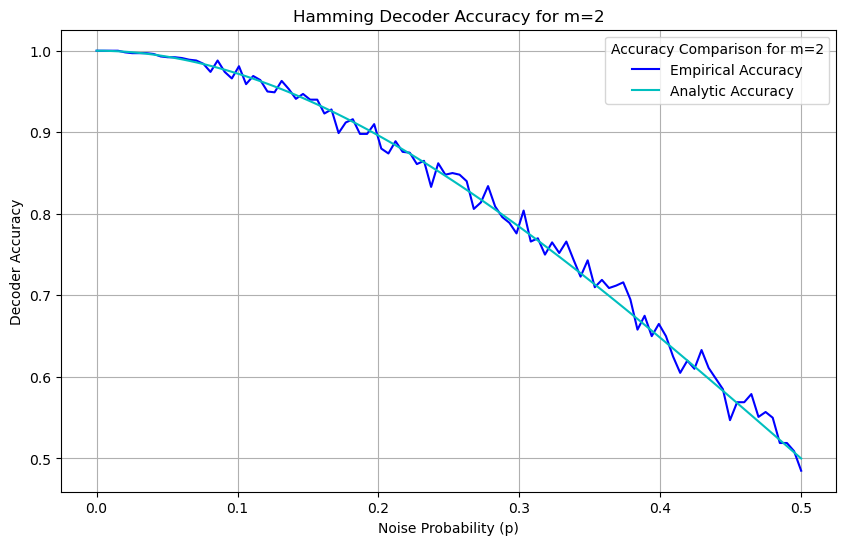

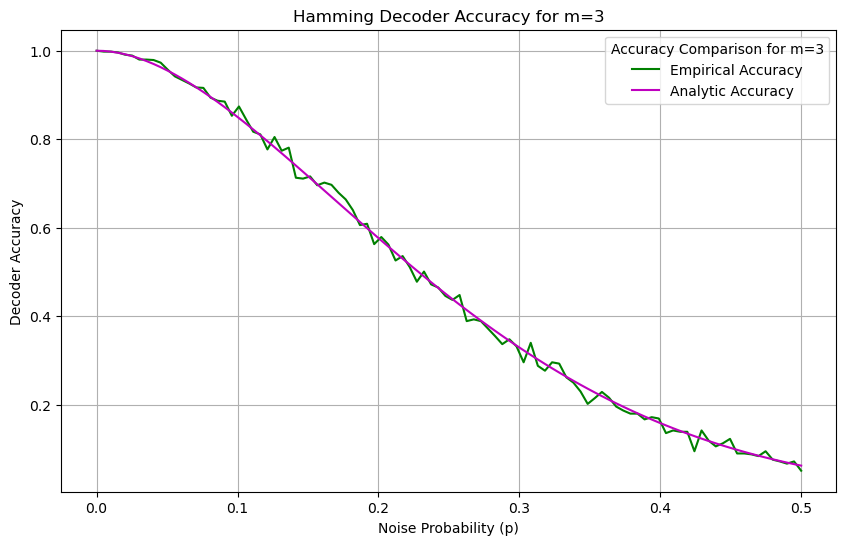

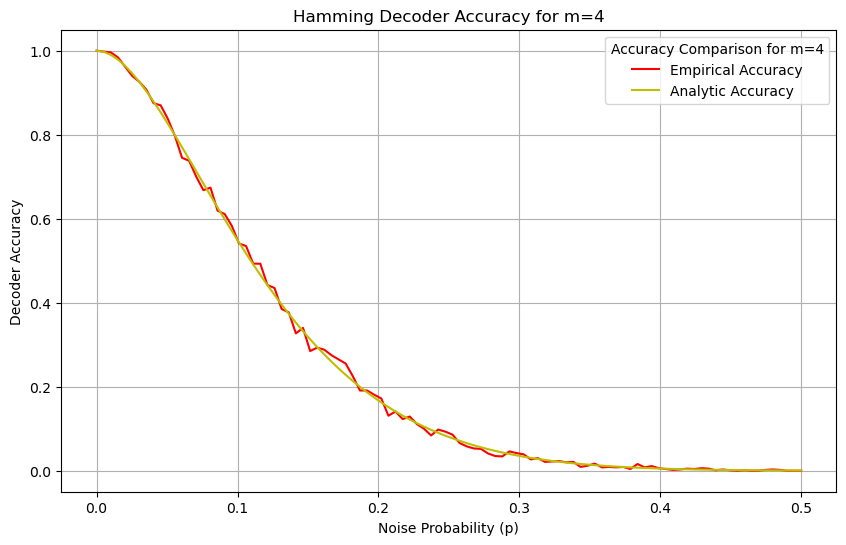

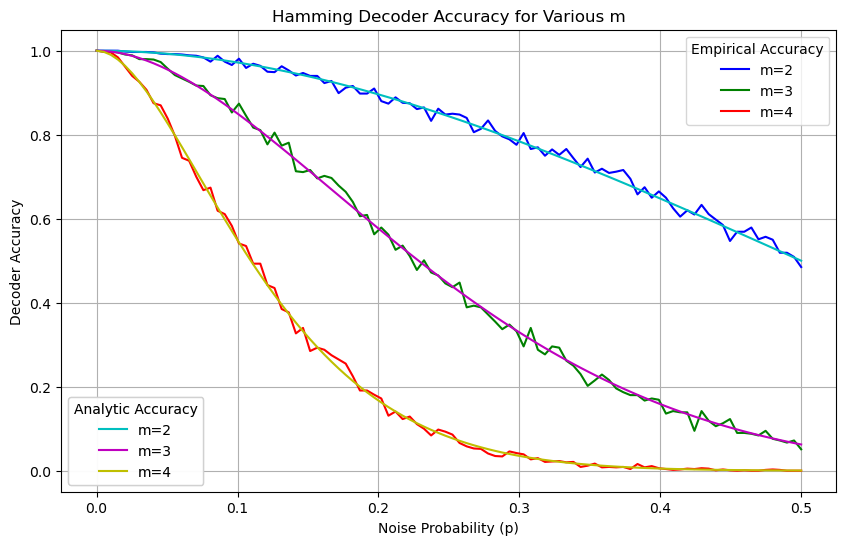

In [24]:
import matplotlib.pyplot as plt

empirical_colors = ["blue", "green", "red"]
analytic_colors = ["c", "m", "y"]

for m, empirical_color, analytic_color in zip(
    m_values, empirical_colors, analytic_colors
):
    plt.figure(figsize=(10, 6))
    plt.plot(
        p_values, accuracy_data[m], color=empirical_color, label=f"Empirical Accuracy"
    )
    plt.plot(
        p_values,
        analytic_accuracy_data[m],
        color=analytic_color,
        label=f"Analytic Accuracy",
    )
    plt.legend(loc="best", title=f"Accuracy Comparison for m={m}")
    plt.title(f"Hamming Decoder Accuracy for m={m}")
    plt.xlabel("Noise Probability (p)")
    plt.ylabel("Decoder Accuracy")
    plt.grid(True)

    plt.savefig(f"images/accuracy_m{m}.png")
    plt.show()
    plt.close()

empirical_handles, empirical_labels = [], []
analytic_handles, analytic_labels = [], []

plt.figure(figsize=(10, 6))

for m, color in zip(m_values, empirical_colors):
    (line,) = plt.plot(p_values, accuracy_data[m], color=color)
    empirical_handles.append(line)
    empirical_labels.append(f"m={m}")


for m, color in zip(m_values, analytic_colors):
    (line,) = plt.plot(p_values, analytic_accuracy_data[m], color=color)
    analytic_handles.append(line)
    analytic_labels.append(f"m={m}")

legend_empirical = plt.legend(
    empirical_handles, empirical_labels, loc="upper right", title="Empirical Accuracy"
)
legend_analytic = plt.legend(
    analytic_handles, analytic_labels, loc="lower left", title="Analytic Accuracy"
)
plt.gca().add_artist(legend_empirical)
plt.gca().add_artist(legend_analytic)

plt.title("Hamming Decoder Accuracy for Various m")
plt.xlabel("Noise Probability (p)")
plt.ylabel("Decoder Accuracy")
plt.grid(True)
plt.savefig("images/accuracy_overlay.png")
plt.show()
plt.close()